In [38]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Callable, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator

@dataclass
class BaseSWIM(BaseEstimator, ABC):
    is_classifier: bool = False
    layer_width: int = None

    activation: Union[Callable[[np.ndarray], np.ndarray], str] = "none"
    weights: np.ndarray = None
    biases: np.ndarray = None
    n_parameters: int = 0

    input_shape: Tuple[int, ...] = None
    output_shape: Tuple[int, ...] = None

    @staticmethod
    def identity_activation(x):
        return x

    @staticmethod
    def relu_activation(x):
        return np.maximum(x, 0)

    @staticmethod
    def tanh_activation(x):
        return np.tanh(x)

    def __post_init__(self):
        self._classes = None

        if not isinstance(self.activation, Callable):
            if self.activation == "none" or self.activation is None:
                self.activation = BaseSWIM.identity_activation
            elif self.activation == "relu":
                self.activation = BaseSWIM.relu_activation
            elif self.activation == "tanh":
                self.activation = BaseSWIM.tanh_activation
            else:
                raise ValueError(f"Unknown activation {self.activation}.")

    @abstractmethod
    def fit(self, x, y=None):
        pass

    def transform(self, x, y=None):
        if self.layer_width is None:
            raise ValueError("The fit method did not set the number of outputs, i.e. layer_width.")
        
        x = self.prepare_x(x)
        result = self.activation(x @ self.weights + self.biases)
        return result

    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x, y)

    def predict(self, x):
        return self.transform(x)
    
    def prepare_x(self, x):
        if len(x.shape) > 2:
            x = x.reshape(x.shape[0], -1)
        return x
    
    def prepare_y(self, y):
        """Prepares labels for the sampling.

        For the classification problem, applies one-hot encoding for the labels.
        For the regression problem, adds a dimension to the labels if neccesary.
        """
        if len(y.shape) < 2:
            y = y.reshape(-1, 1)

        if not self.is_classifier:
            return y, y 
        
        self._classes = np.unique(y)  
        n_classes = len(self._classes)
        y_encoded_index = np.argmax(y == self._classes, axis=1)
        y_encoded_onehot = np.eye(n_classes)[y_encoded_index]
        return y_encoded_onehot, y_encoded_index.reshape(-1, 1)  


    def prepare_y_inverse(self, y):
        """Inverse to prepare_y(self, y).

        For the classification problem, restores labels from the one-hot predictions.
        For the regression problem, has no effect on the labels.
        """
        if not self.is_classifier:
            return y 
        
        probability_max = np.argmax(y, axis=1)
        predictions = self._classes[probability_max].reshape(-1, 1)
        return predictions
    
    def clean_inputs(self, x, y):
        x = self.prepare_x(x)
        y, _ = self.prepare_y(y)
        return x, y
    

#######################  |
##### Dense Layer #####  |
####################### \|/

@dataclass
class DenseSWIM(BaseSWIM):
    parameter_sampler: Union[Callable, str] = "relu"
    sample_uniformly: bool = False
    random_seed: int = 1
    dist_min: np.float64 = 1e-10
    repetition_scaler: int = 1

    idx_from: np.ndarray = None
    idx_to: np.ndarray = None

    def __post_init__(self):
        super().__post_init__()
        
        if not isinstance(self.parameter_sampler, Callable):
            if self.parameter_sampler == "relu":
                self.parameter_sampler = self.sample_parameters_relu
            elif self.parameter_sampler == "tanh":
                self.parameter_sampler = self.sample_parameters_tanh
            elif self.parameter_sampler == "random":
                self.parameter_sampler = self.sample_parameters_randomly
            else:
                raise ValueError(f"Unknown parameter sampler {self.parameter_sampler}.")

    def fit(self, x, y=None):
        if self.layer_width is None:
            raise ValueError("layer_width must be set.")
        
        x, y = self.clean_inputs(x, y)
        rng = np.random.default_rng(self.random_seed)

        weights, biases, idx_from, idx_to = self.parameter_sampler(x, y, rng)

        self.idx_from = idx_from
        self.idx_to = idx_to
        self.weights = weights
        self.biases = biases

        self.n_parameters = np.prod(weights.shape) + np.prod(biases.shape)
        return self

    def sample_parameters_tanh(self, x, y, rng):
        scale = 0.5 * (np.log(1 + 1/2) - np.log(1 - 1/2))

        directions, dists, idx_from, idx_to = self.sample_parameters(x, y, rng)
        weights = (2 * scale * directions / dists).T
        biases = -np.sum(x[idx_from, :] * weights.T, axis=-1).reshape(1, -1) - scale

        return weights, biases, idx_from, idx_to

    def sample_parameters_relu(self, x, y, rng):
        scale = 1.0

        directions, dists, idx_from, idx_to = self.sample_parameters(x, y, rng)
        weights = (scale / dists.reshape(-1, 1) * directions).T
        biases = -np.sum(x[idx_from, :] * weights.T, axis=-1).reshape(1, -1)

        return weights, biases, idx_from, idx_to
    
    def sample_parameters_randomly(self, x, _, rng):
        weights = rng.normal(loc=0, scale=1, size=(self.layer_width, x.shape[1])).T
        biases = rng.uniform(low=-np.pi, high=np.pi, size=(self.layer_width, 1)).T
        idx0 = None
        idx1 = None
        return weights, biases, idx0, idx1
    
    def sample_parameters(self, x, y, rng):
        """
        Sample directions from points to other points in the given dataset (x, y).
        """

        # n_repetitions repeats the sampling procedure to find better directions.
        # If we require more samples than data points, the repetitions will cause more pairs to be drawn.
        n_repetitions = max(1, int(np.ceil(self.layer_width / x.shape[0]))) * self.repetition_scaler

        # This guarantees that:
        # (a) we draw from all the N(N-1)/2 - N possible pairs (minus the exact idx_from=idx_to case)
        # (b) no indices appear twice at the same position (never idx0[k]==idx1[k] for all k)
        candidates_idx_from = rng.integers(low=0, high=x.shape[0], size=x.shape[0]*n_repetitions)
        delta = rng.integers(low=1, high=x.shape[0]-1, size=candidates_idx_from.shape[0])
        candidates_idx_to = (candidates_idx_from + delta) % x.shape[0]
        
        directions = x[candidates_idx_to, ...] - x[candidates_idx_from, ...]
        dists = np.linalg.norm(directions, axis=1, keepdims=True)
        dists = np.clip(dists, a_min=self.dist_min, a_max=None)
        directions = directions / dists

        dy = y[candidates_idx_to, :] - y[candidates_idx_from, :]
        if self.is_classifier:
            dy[np.abs(dy) > 0] = 1

        # We always sample with replacement to avoid forcing to sample low densities
        probabilities = self.weight_probabilities(dy, dists)
        selected_idx = rng.choice(dists.shape[0],
                                  size=self.layer_width,
                                  replace=True,
                                  p=probabilities)
        directions = directions[selected_idx]
        dists = dists[selected_idx]
        idx_from = candidates_idx_from[selected_idx]
        idx_to = candidates_idx_to[selected_idx]
        
        return directions, dists, idx_from, idx_to
    

    def weight_probabilities(self, dy, dists):
        """Compute probability that a certain weight should be chosen as part of the network.
        This method computes all probabilities at once, without removing the new weights one by one.

        Args:
            dy: function difference
            dists: distance between the base points
            rng: random number generator

        Returns:
            probabilities: probabilities for the weights.
        """
        # compute the maximum over all changes in all y directions to sample good gradients for all outputs
        gradients = (np.max(np.abs(dy), axis=1, keepdims=True) / dists).ravel()

        if self.sample_uniformly or np.sum(gradients) < self.dist_min:
            # When all gradients are small, avoind dividing by a small number
            # and default to uniform distribution.
            probabilities = np.ones_like(gradients) / len(gradients)
        else:
            probabilities = gradients / np.sum(gradients)

        return probabilities

[[ 1.          0.91786576  0.97119642 ...  0.10872611  0.13431732
   0.13633535]
 [ 1.          0.98114949  0.96572542 ... -0.08060169 -0.06387692
  -0.08158227]
 [ 1.          0.98778857  0.94799199 ...  0.14938361  0.17765122
   0.19218885]
 ...
 [ 1.          0.9329587   0.90914964 ...  0.21209306  0.22377056
   0.16710494]
 [ 1.          0.9418147   0.94379666 ...  0.02877331  0.05306628
   0.04263984]
 [ 1.          0.94543838  0.9592439  ... -0.0761567  -0.07829631
  -0.07590369]]


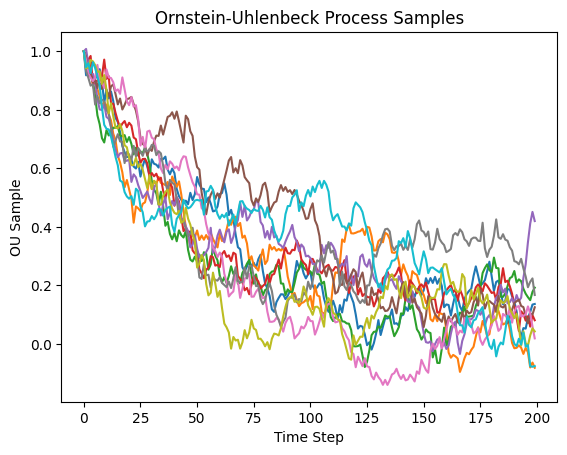

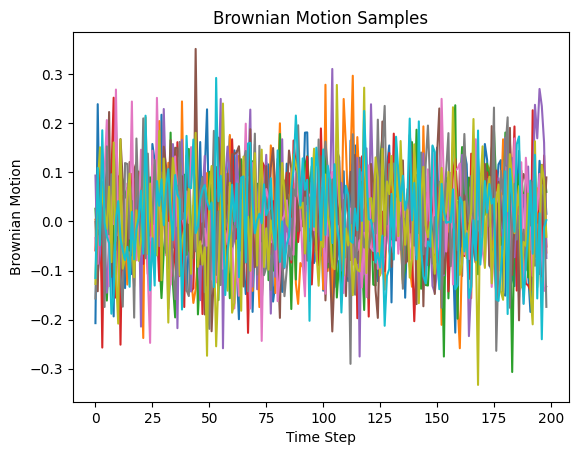

In [54]:
def generate_OU_1d(n_samples, n_steps, dt, theta, mu, sigma, x0):
    """
    Simulate a 1-dimensional Ornstein-Uhlenbeck process using the Milstein method.

    Parameters:
        n_samples (int): Number of samples to generate.
        n_steps (int): Number of time steps to simulate.
        dt (float): Time increment between steps.
        theta (float): Mean reversion rate.
        mu (float): Long-term mean.
        sigma (float): Volatility.
        x0 (float): Initial value.

    Returns:
        numpy.ndarray: Array of shape (n_steps,) with the simulated process.
    """
    # Preallocate array for the process values
    X = np.zeros( (n_samples, n_steps) )
    X[:, 0] = x0

    dW = np.random.randn(n_samples, n_steps-1) * np.sqrt(dt)

    # Generate the 1D OU process using the Milstein method
    for t in range(1, n_steps):
        # Generate standard normal random variable for Wiener process increment

        X[:, t] = X[:, t-1] + theta * (mu - X[:, t-1]) * dt + sigma * dW[:, t-1]

    return X, dW

# Example usage
n_samples = 10000  # Number of samples
n_steps = 200  # Number of time steps
dt = 0.01       # Time step size
theta = 2.0     # Mean reversion rate
mu = 0.0        # Long-term mean
sigma = 0.3     # Volatility
x0 = 1.0        # Initial value

# Generate samples
OU_samples, dW = generate_OU_1d(n_samples, n_steps, dt, theta, mu, sigma, x0)

# Print the first few samples
print(OU_samples[:10])
import matplotlib.pyplot as plt

# Plot the OU samples
plt.plot(OU_samples[:10].T)
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Ornstein-Uhlenbeck Process Samples')
plt.show()

plt.plot(dW[:10].T)
plt.xlabel('Time Step')
plt.ylabel('Brownian Motion')
plt.title('Brownian Motion Samples')
plt.show()

Best alpha: 0.01
R^2 score: 0.999999958656735


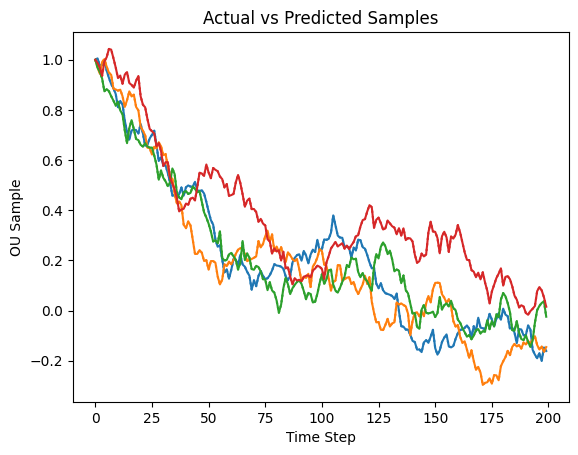

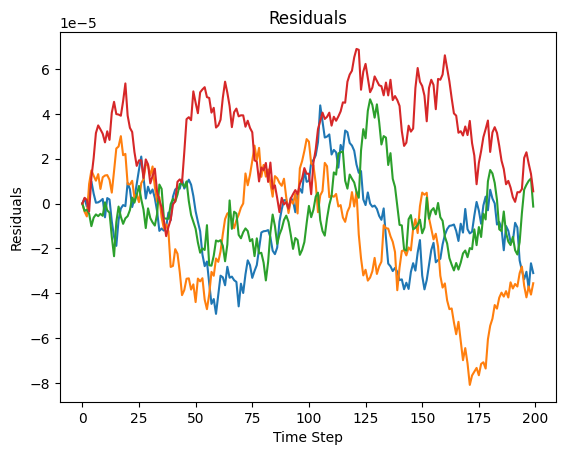

In [55]:
from sklearn.linear_model import RidgeCV

# Create the ridge regression model
ridge_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
n = len(OU_samples)
train_OU = OU_samples[:n//2]
test_OU = OU_samples[n//2:]
train_dW = dW[:n//2]
test_dW = dW[n//2:]


# Fit the model to the data
ridge_model.fit(train_dW, train_OU)
print("Best alpha:", ridge_model.alpha_)
print("R^2 score:", ridge_model.score(train_dW, train_OU))

# Predict the OU samples using the noise
pred = ridge_model.predict(test_dW)
# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

alpha: 0.01
R^2 score: 0.9999608153298705
l2 relative 0.0016414161862239034


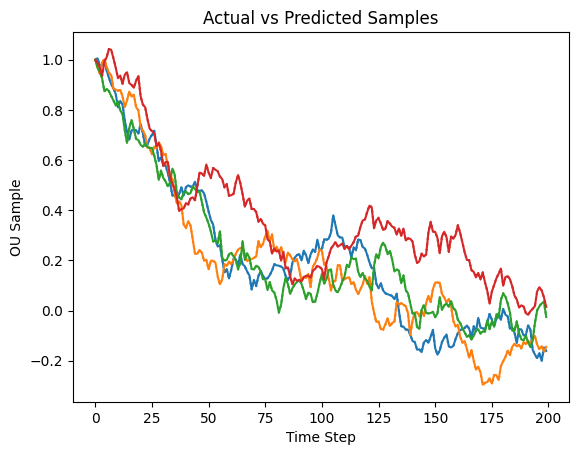

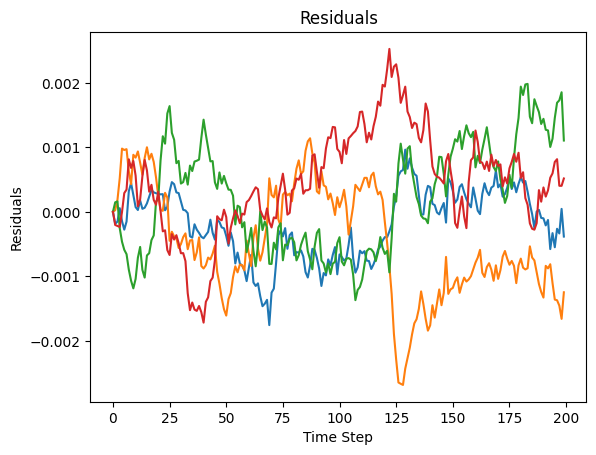

In [57]:
###### Test dense layer ######
from sklearn.pipeline import Pipeline
from time import time


def l2_error_relative(f_approx, f_true):
    return np.linalg.norm(f_approx-f_true, ord=2) / np.linalg.norm(f_true, ord=2)


def train_sampling(x_train, y_train, n_layers, n_width, random_seed=1):
    steps = []
    for k_layer in range(n_layers):
        steps.append((f"fcn{k_layer+1}", DenseSWIM(layer_width=n_width, 
                                                   activation="relu", 
                                                   parameter_sampler='relu', 
                                                   random_seed=1 + random_seed + k_layer * 1234)))
    steps.append(("ridgeCV", RidgeCV(alphas=[0.01])))
    model = Pipeline(steps=steps, verbose=False)
    t0 = time()
    model.fit(x_train, y_train)
    t_fit = time()
    return model, t_fit-t0


n_layers = 1
n_width = 256

model, time_fit = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_dW, y_train=train_OU)
l2_relative = l2_error_relative(model.predict(test_dW), test_OU)
print("alpha:", model.named_steps['ridgeCV'].alpha_)
print("R^2 score:", model.score(test_dW, test_OU))
print("l2 relative", l2_relative)

# Predict the OU samples using the noise
pred = model.predict(test_dW)
# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()